<a href="https://colab.research.google.com/github/seungmindavid/Representational_Learning/blob/main/GAN/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pathlib
import torchvision

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt



# Wasserstein Generative Adversarial Networks (WGANs)

- JS Divergence has gradient issues which lead to unstable training. WGAN bases its loss from Wasserstein Distance.

$\text{max}_{||f|| \leq 1}\mathbb{E}_{x \sim \mathbb{P}_r}[f(x)] - \mathbb{E}_{x \sim \mathbb{P}_θ}[f(x)]$

Critic: maximize separation

Generator: minimize separation.

- After every gradient update on the critic function, clamp the weights to a small fixed range, [-c,c] to remain 1 Lipschitz Continuous.
- Use a new loss function derived from Wasswersetein distance. The critic model does not play as a direct critic but a helper for estimating the Wasswersetein metric between real and genenearted data distribution.
- Empirically, the authors recommended RMSProp optimizer on the critic rather than Adam which could cause instability in the model training.


# Loading Dataset (MNIST)
Batch size
- Train dataset: 128 batch size
- Test dataset: 10 batch

## Details of adversarial training
- batch size: 128
- All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02
- In the LeakyReLU, the slope of the leak was set to 0.2 in all models


In [2]:
batch_size_train = 128
batch_size_test = 10
img_size = 28

# mean and standard deviation for mnist dataset: 0.1307, 0.3081
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 137418562.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 60719646.03it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 126980967.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22177565.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Loss Construction
- Discriminator: $\text{min}_G \text{max}_D \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1-D(G(z)))]$, with fixed G (Generator).
- $L_{dis} = BCE(D(x), 1) + BCE(D(G(z)), 0)$


- Generator: $\text{max}_G\mathbb{E}_{z\sim p_{z}(z)}[log(D(G(z)))]$ which is equal to $\text{min}_G\mathbb{E}_{z\sim p_{z}(z)}[1-log(D(G(z)))]$ with fixed D
(Discriminator)
- $L_{gen} = -BCE(D(G(z)), 0) = BCE(D(G(z)), 1)$

- The rationale for transitioning the generator from a minimization objective to a maximization objective lies in the common observation that, initially, the discriminator typically exhibits superior performance over the generator. This phenomenon lead $D(G(z))$ to outproduce 0. Particularly, when $x=0$, $log(x)$ has steeper gradient than $log(1-x)$, which faciliates the more efficient training of the Generator.


# Building Discriminator & Generator
- [Linear → LeakyReLU] × 4 using increasing linear layer sizes, e.g., 128 → 256 → 512 → 1024 → (28 ∗ 28). LeakyReLU often replaces the ReLU non-linearity in direct generative models both in convolutional generators and fully connected generators.
- Generator: 128 → 256 → 512 → 1024 → (28 ∗ 28)
- Discriminator: (28 ∗ 28) → 1024 → 512 → 256 → 128 -> 1

In [3]:
class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(128, 256),
        nn.BatchNorm1d(256, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256,512),
        nn.BatchNorm1d(512, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,1024),
        nn.BatchNorm1d(1024, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(1024, img_dim),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.gen(x)

In [4]:
class Critic(nn.Module):
  def __init__(self, img_dim):
    super(Critic, self).__init__()
    self.disc = nn.Sequential(
        nn.Linear(img_dim, 1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(128, 1), # we need score for wgan
        #nn.Sigmoid(), # not a [0,1] binary output
    )
  def forward(self, x):
    return self.disc(x)



# Training WGAN (without gradient penalty)


In [5]:
# Save model
saved_params_path = "./saved_params_dcgan"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# Hyperparameters
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

lr = 3e-4
z_dim = 100
image_dim = 28*28*1
num_epochs = 100
critic_iteration = 5
weight_clip = 0.01

Gen_Loss = []
Cri_Loss = []

cri = Critic(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
cri_optim = optim.RMSprop(cri.parameters(), lr=lr)
gen_optim = optim.RMSprop(gen.parameters(), lr=lr)


for epoch in range(num_epochs):
  for i, data in enumerate(train_loader, 0):
    real, labels = data
    real = real.view(-1, image_dim).to(device)
    batch_size = real.shape[0]

    # Train Critic
    # Critic loss: D(x) - D(G(z))
    # Objective: Maximize Critic loss: -D(x) + (-D(G(z)))
    for _ in range(critic_iteration):
      #cri.zero_grad()

      noise = torch.randn(batch_size, z_dim).to(device)
      fake = gen(noise)

      D_x = cri(real).view(-1)
      D_G_z = cri(fake).view(-1)

      Critic_loss = -torch.mean(D_x) + torch.mean(D_G_z)
      cri.zero_grad()
      Critic_loss.backward(retain_graph = True)
      cri_optim.step()
      ## Clipping weights of critic
      for p in cri.parameters():
        p.data.clamp_(-weight_clip, weight_clip)

    # Train Generator:
    # Generator loss: D(G(z))
    D_G_z = cri(fake).view(-1)
    Generator_loss = -torch.mean(D_G_z)
    gen.zero_grad()
    Generator_loss.backward()
    gen_optim.step()

  print(f"Epoch [{epoch+1}/{num_epochs}]\
        Critic Loss: {Critic_loss.item():.4f}, loss G: {Generator_loss.item():.4f}")
  Gen_Loss.append(Generator_loss.item())
  Cri_Loss.append(Critic_loss.item())
  torch.save(cri.state_dict(), f'{saved_params_path}/critic_{epoch}.pth')
  torch.save(gen.state_dict(), f'{saved_params_path}/generator_{epoch}.pth')


GPU
Epoch [1/100]        Critic Loss: -0.0022, loss G: 0.0108
Epoch [2/100]        Critic Loss: -0.0024, loss G: 0.0111
Epoch [3/100]        Critic Loss: -0.0019, loss G: 0.0108
Epoch [4/100]        Critic Loss: -0.0022, loss G: 0.0111
Epoch [5/100]        Critic Loss: -0.0019, loss G: 0.0110
Epoch [6/100]        Critic Loss: -0.0021, loss G: 0.0111
Epoch [7/100]        Critic Loss: -0.0021, loss G: 0.0111
Epoch [8/100]        Critic Loss: -0.0023, loss G: 0.0111
Epoch [9/100]        Critic Loss: -0.0020, loss G: 0.0110
Epoch [10/100]        Critic Loss: -0.0022, loss G: 0.0110
Epoch [11/100]        Critic Loss: -0.0015, loss G: 0.0110
Epoch [12/100]        Critic Loss: -0.0019, loss G: 0.0109
Epoch [13/100]        Critic Loss: -0.0021, loss G: 0.0108
Epoch [14/100]        Critic Loss: -0.0019, loss G: 0.0111
Epoch [15/100]        Critic Loss: -0.0020, loss G: 0.0108
Epoch [16/100]        Critic Loss: -0.0017, loss G: 0.0112
Epoch [17/100]        Critic Loss: -0.0020, loss G: 0.0111
Ep

# Plotting Critic vs Generator

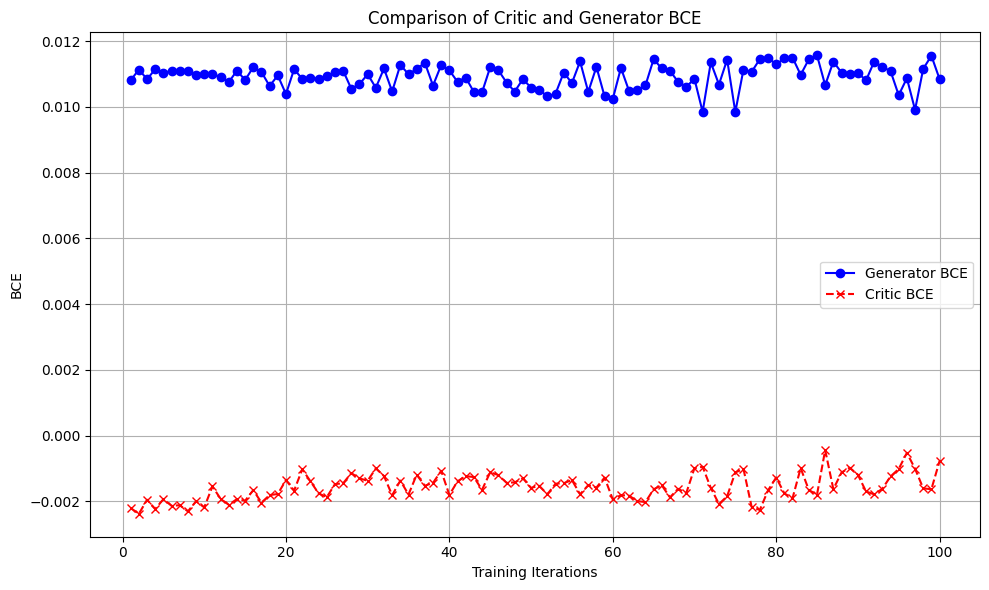

In [6]:
import matplotlib.pyplot as plt

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(Gen_Loss) + 1)

# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, Gen_Loss, label='Generator BCE', marker='o', linestyle='-', color='b')
plt.plot(iterations, Cri_Loss, label='Critic BCE', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('BCE')
plt.title('Comparison of Critic and Generator BCE')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

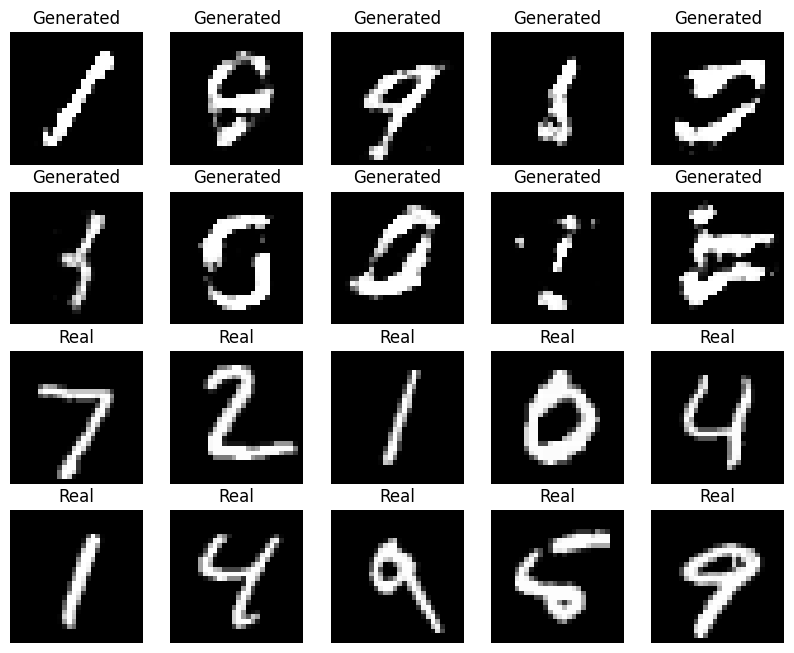

In [7]:
#gen.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))
gen.eval()

fixed_noise = torch.randn((batch_size_test, z_dim)).to(device)
generated_images = gen(fixed_noise)

real_images, _ = next(iter(test_loader))
real_images = real_images.view(real_images.size(0), -1).numpy()

import matplotlib.pyplot as plt

# Display generated and real images in a 4x4 grid
plt.figure(figsize=(10, 10))

for i in range(20):
    plt.subplot(5, 5, i + 1)
    if i < 10:
        plt.imshow(generated_images[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
        plt.title('Generated')
    else:
        plt.imshow(real_images[i - 10].reshape(28, 28), cmap='gray')
        plt.title('Real')
    plt.axis('off')



In [8]:
ㅈreal_images, _ = next(iter(test_loader))
print(real_images.shape)


torch.Size([10, 1, 28, 28])


In [11]:
torch.Size([10, 1, 32, 32])
(10, 1024)

torch.Size([10, 1, 32, 32])